In [1]:
path = []
# !pip install plotly==4.14.3

In [2]:
import os
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        path.append(os.path.join(dirname, filename))

In [3]:
import pandas as pd
import numpy as np
import re
import sklearn
# import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC

from sklearn.model_selection import KFold

In [4]:
train = pd.read_csv("./data/train.csv")
test  = pd.read_csv("./data/test.csv")
submission = pd.read_csv("./data/gender_submission.csv")
combine = [train, test]
# full_data = [train, test]

In [5]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract('([A-Za-z]+)\.', expand = False)

train['name_len'] = train.Name.apply(len)
test['name_len'] = test.Name.apply(len)
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)


In [6]:
print('Train columns with null values:\n', train.isnull().sum())

Train columns with null values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title            0
name_len         0
Has_Cabin        0
dtype: int64


In [7]:
for dataset in combine:
    #complete missing age with median
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)
    #complete embarked with mode
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)
    #complete missing fare with median
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)


In [8]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,name_len,Has_Cabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,23,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,51,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,22,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,44,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,24,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Rev,21,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Miss,28,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,W./C. 6607,23.4500,NaN,S,Miss,40,0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,Mr,21,1


In [9]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in combine:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in combine:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

In [10]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [11]:
for dataset in combine:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [12]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
# from xgboost import XGBClassifier
#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics


ModuleNotFoundError: No module named 'xgboost'

In [14]:
label = LabelEncoder()
for dataset in combine:
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['Age'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['Fare'])

In [15]:
train_X = combine[0]
test_X = combine[1]

In [65]:
#delete the cabin feature/column and others previously stated to exclude in train dataset
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train_X.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test_X.drop(drop_elements, axis = 1)

print(train.isnull().sum())
print("-"*10)
print(test.isnull().sum())


Survived         0
Pclass           0
Sex              0
Age              0
Parch            0
Fare             0
Embarked         0
Title            0
name_len         0
Has_Cabin        0
FamilySize       0
IsAlone          0
Age*Class        0
Sex_Code         0
Embarked_Code    0
Title_Code       0
AgeBin_Code      0
FareBin_Code     0
dtype: int64
----------
Pclass           0
Sex              0
Age              0
Parch            0
Fare             0
Embarked         0
Title            0
name_len         0
Has_Cabin        0
FamilySize       0
IsAlone          0
Age*Class        0
Sex_Code         0
Embarked_Code    0
Title_Code       0
AgeBin_Code      0
FareBin_Code     0
dtype: int64


In [66]:
# y_train = train.pop("Survived")
# (list(train.columns), list(train_X.columns))
# [item for item in list(train.columns) if item not in list(train_X.columns)]

In [42]:
train

,Pclass,Parch,name_len,Has_Cabin,FamilySize,IsAlone,Age*Class,Sex_Code,Embarked_Code,Title_Code,AgeBin_Code,FareBin_Code
0,3,0,23,0,2,0,3,1,0,0,1,0
1,1,0,51,1,2,0,2,0,1,2,2,3
2,3,0,22,0,1,1,3,0,0,1,1,1
3,1,0,44,1,2,0,2,0,0,2,2,3
4,3,0,24,0,1,1,6,1,0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,0,21,0,1,1,2,1,0,4,1,1
887,1,0,28,1,1,1,1,0,0,1,1,2
888,3,2,40,0,4,0,3,0,0,1,1,2
889,1,0,21,1,1,1,1,1,1,0,1,2


<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

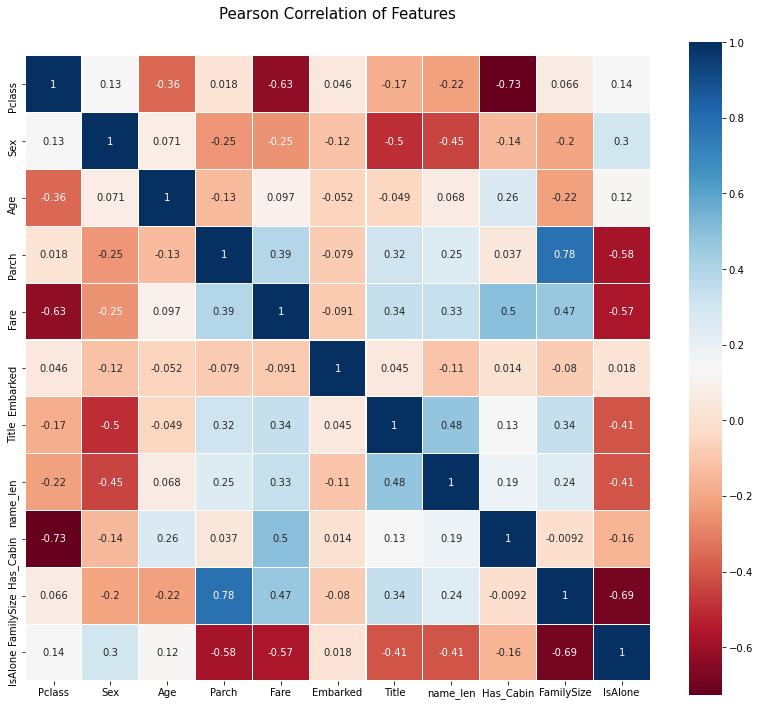

In [22]:
# colormap = plt.cm.RdBu
# plt.figure(figsize=(14,12))
# plt.title('Pearson Correlation of Features', y=1.05, size=15)
# sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0,
#             square=True, cmap=colormap, linecolor='white', annot=True)

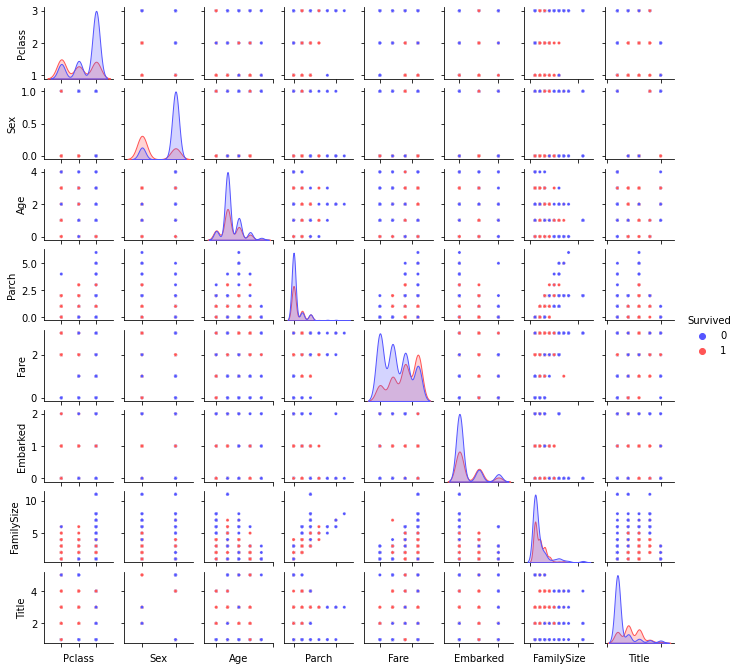

In [31]:
# g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
#        u'FamilySize', u'Title']],
#                  hue='Survived',
#                  palette = 'seismic', size=1.2,
#                  diag_kind = 'kde', diag_kws=dict(shade=True), plot_kws=dict(s=10) )
# g.set(xticklabels=[])

---

# go ML
# --------------------------------------------

In [67]:
train = train.drop(['Sex', 'Age', 'Embarked', 'Title', 'Fare'], axis = 1)
test  = test.drop (['Sex', 'Age', 'Embarked', 'Title', 'Fare'], axis = 1)

In [68]:
train.dtypes

Survived         int64
Pclass           int64
Parch            int64
name_len         int64
Has_Cabin        int64
FamilySize       int64
IsAlone          int64
Age*Class        int64
Sex_Code         int64
Embarked_Code    int64
Title_Code       int64
AgeBin_Code      int64
FareBin_Code     int64
dtype: object

# corr table of Target and variables.

In [17]:
# for x in train:
#     if train[x].dtype != 'float64' :
#         print('Survival Correlation by:', x)
#         print(train[[x, Target[0]]].groupby(x, as_index=False).mean())
#         print('-'*10, '\n')
# #using crosstabs: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.crosstab.html
# print(pd.crosstab(train['Title'],train[Target[0]]))

In [18]:
categorical_cols = [cname for cname in train.columns if
                    train[cname].nunique() < 10 or
                   train[cname].dtype == 'object']


In [19]:
# [item for item in train.columns if item not in categorical_cols] # name len

In [69]:
Target = train.pop('Survived') # Target series 891
# train['Survived'] = Target

In [51]:
Target = Target.iloc[1:]
# train_X = pd.DataFrame(OneHotEncoder.fit_transform(train[categorical_cols], X=1))
# (Target, train, test)

In [26]:
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 )
#

In [27]:
# DecisionTreeClassifier  # 0.7828358208955223
alg1 = tree.DecisionTreeClassifier(random_state=1)
cv_results_1 = model_selection.cross_validate(alg1, train, Target, cv  = cv_split)
cv_results_1['test_score'].mean()

In [31]:
# LogisticRegressionCV # 0.8059701492537314
alg2 = linear_model.LogisticRegressionCV(random_state=1)
cv_results_2 = model_selection.cross_validate(alg2, train, Target, cv  = cv_split)
cv_results_2['test_score'].mean()
# ensemble.BaggingClassifier?

In [70]:
# BernoulliNB # 0.7854477611940298
model_selection.cross_validate(naive_bayes.BernoulliNB(), train, Target, cv  = cv_split)['test_score'].mean()


0.7854477611940298

In [36]:
# KNeighborsClassifier # 0.7458955223880596
model_selection.cross_validate(neighbors.KNeighborsClassifier(), train, Target, cv  = cv_split)['test_score'].mean()

0.7458955223880596

In [94]:
# RandomForestClassifier  # 0.8022388059701493
model_selection.cross_validate(ensemble.RandomForestClassifier(), train, Target, cv  = cv_split)['test_score'].mean()

0.8022388059701493

In [95]:
# ExtraTreesClassifier # 0.8041044776119403
model_selection.cross_validate(ensemble.ExtraTreesClassifier(), train, Target, cv  = cv_split)['test_score'].mean()

0.8041044776119403

In [96]:
# GradientBoostingClassifier # 0.8186567164179104
model_selection.cross_validate(ensemble.GradientBoostingClassifier(), train, Target, cv  = cv_split)['test_score'].mean()

0.8186567164179104

In [71]:
MLA = [
    #Ensemble Methods
    # ensemble.AdaBoostClassifier(),
    # ensemble.BaggingClassifier(),
    # ensemble.ExtraTreesClassifier(),
    # ensemble.GradientBoostingClassifier(),
    # ensemble.RandomForestClassifier(),
    #
    # #Gaussian Processes|
    # gaussian_process.GaussianProcessClassifier(),

    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),

    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),

    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),

    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),

    #Trees
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),

    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis()


    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    # XGBClassifier()
    ]

In [72]:
MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
# 'MLA Train Accuracy Mean',

In [73]:
MLA_compare = pd.DataFrame(columns = MLA_columns)
MLA_predict = Target
row_index = 0

In [74]:
# MLA and save performance to table


for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())

    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, train, Target, cv  = cv_split)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    # MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!


    #save MLA predictions - see section 6 for usage
    # alg.fit(train, Target)
    # MLA_predict[MLA_name] = alg.predict(train)

    row_index+=1


#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

,MLA Name,MLA Parameters,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
0,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.80597,0.073404,0.274111
9,NuSVC,"{'break_ties': False, 'cache_size': 200, 'clas...",0.80597,0.05461,0.021943
2,RidgeClassifierCV,"{'alphas': array([ 0.1, 1. , 10. ]), 'class_w...",0.80597,0.061516,0.002696
13,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.803731,0.061149,0.002644
14,QuadraticDiscriminantAnalysis,"{'priors': None, 'reg_param': 0.0, 'store_cova...",0.78694,0.072796,0.002106
6,GaussianNB,"{'priors': None, 'var_smoothing': 1e-09}",0.785821,0.081678,0.001416
5,BernoulliNB,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.785448,0.05757,0.001386
10,LinearSVC,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.785448,0.160918,0.018447
11,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.781716,0.06832,0.001837
12,ExtraTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.772015,0.065166,0.001519


In [75]:
MLA_compare

,MLA Name,MLA Parameters,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
0,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.80597,0.073404,0.274111
9,NuSVC,"{'break_ties': False, 'cache_size': 200, 'clas...",0.80597,0.05461,0.021943
2,RidgeClassifierCV,"{'alphas': array([ 0.1, 1. , 10. ]), 'class_w...",0.80597,0.061516,0.002696
13,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.803731,0.061149,0.002644
14,QuadraticDiscriminantAnalysis,"{'priors': None, 'reg_param': 0.0, 'store_cova...",0.78694,0.072796,0.002106
6,GaussianNB,"{'priors': None, 'var_smoothing': 1e-09}",0.785821,0.081678,0.001416
5,BernoulliNB,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.785448,0.05757,0.001386
10,LinearSVC,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.785448,0.160918,0.018447
11,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.781716,0.06832,0.001837
12,ExtraTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.772015,0.065166,0.001519


In [92]:
# fig = ff.create_table(pd.DataFrame(MLA_compare))
# fig.update_layout(
#     autosize=False,
#     width=500,
#     height=200,
# )
# fig.write_image("table_plotly.png", scale=2)

ValueError: 
The orca executable is required to export figures as static images,
but it could not be found on the system path.

Searched for executable 'orca' on the following path:
    /Users/fyenne/miniforge3/envs/tf24/bin
    /opt/homebrew/bin
    /Users/fyenne/anaconda3/bin
    /Users/fyenne/anaconda3/condabin
    /Users/fyenne/.pyenv/plugins/pyenv-virtualenv/shims
    /Users/fyenne/.pyenv/shims
    /Users/fyenne/.pyenv/plugins/pyenv-virtualenv/shims
    /Library/Frameworks/Python.framework/Versions/3.9/bin
    /usr/local/bin
    /usr/bin
    /bin
    /usr/sbin
    /sbin
    /Users/fyenne/anaconda3/bin/python
    /Users/fyenne/python_online/chromedriver
    /Library/TeX/texbin
    /usr/local/go/bin
    /usr/local/aria2/bin
    /usr/local/share/dotnet
    /opt/X11/bin
    ~/.dotnet/tools

If you haven't installed orca yet, you can do so using conda as follows:

    $ conda install -c plotly plotly-orca

Alternatively, see other installation methods in the orca project README at
https://github.com/plotly/orca

After installation is complete, no further configuration should be needed.

If you have installed orca, then for some reason plotly.py was unable to
locate it. In this case, set the `plotly.io.orca.config.executable`
property to the full path of your orca executable. For example:

    >>> plotly.io.orca.config.executable = '/path/to/orca'

After updating this executable property, try the export operation again.
If it is successful then you may want to save this configuration so that it
will be applied automatically in future sessions. You can do this as follows:

    >>> plotly.io.orca.config.save()

If you're still having trouble, feel free to ask for help on the forums at
https://community.plot.ly/c/api/python


In [81]:
import plotly.figure_factory as ff
import pandas as pd

In [91]:
os.getcwd()

'/Users/fyenne/Downloads/booooks/semester5/tf24/titanic_kaggle'

In [103]:
test.to_csv("./test.csv", index=  False)
train.to_csv("./train.csv", index = False)

In [104]:
Target.to_csv("./target.csv", index = False)